# Faostat global model
In this notebook we create an ensemble of multilayer perceptron ([MLP](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)) models to fit the world crop yields using the input variables: precipitation, air temperature, natural and synthetic fertilizers.

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print("Matplotlib version: %s"%mpl.__version__)

NumPy version: 1.25.2
Pandas version: 2.1.1
Matplotlib version: 3.8.0


## The dataset
We load the dataset that was prepared by putting into the same file the predictors and the predictands data

In [5]:
global_crop_yield_path = 'data/global_dataset.csv'
global_crop_yield_df = pd.read_csv(global_crop_yield_path, index_col=0)
global_crop_yield_df.head(2)

,Maize (100g/ha),Millet (100g/ha),Temp. Anom. (°C),Prec.Anom. (mm),CO2 (ppm),Manure (Mt),Nitrogen (tons),Phosphate (tons),Potash (tons)
1961-12-31,19423,5925,0.211,15.318908,317.64,1.835092e+10,11486265.27,10888968.81,8626724.57
1962-12-31,19796,5619,0.038,0.768900,318.45,1.872918e+10,12969831.11,11534554.43,9146891.38


## Data preparation
Since the values for the variables differ by orders of magnitude, we normalize them before using the data as input for the model. We use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) from the scikit-learn package to normalize the values. The scaler removes the mean and scale the values to unit variance. We start by selecting the columns with the input data

In [20]:
X = global_crop_yield_df.iloc[:, [2, 3, 4, 5, 6, 7, 8]].to_numpy()
y = global_crop_yield_df.iloc[:, [0]].to_numpy()

and the column of the predictand (maize)

In [22]:
y[:1]

array([[19423]], dtype=int64)

In [65]:
from sklearn import preprocessing
scaler_x = preprocessing.StandardScaler().fit(X)

The scaler computes the mean of the input variables

In [66]:
mean_x = scaler_x.mean_[0]
mean_x

0.5707741935483871

and the variance

In [67]:
variance_x = scaler_x.scale_[0]
variance_x

0.5387043721971724

we use the scaler to normalize the input variables

In [68]:
X_scaled = scaler_x.transform(X)
X_scaled[:2]

array([[-0.66785089,  0.77731939, -1.40643863, -2.40701305, -1.98495063,
        -2.28283496, -2.01318626],
       [-0.98899178, -0.19056567, -1.37931664, -2.24857187, -1.9350268 ,
        -2.21423612, -1.94657282]])

In [69]:
scaler_y = preprocessing.StandardScaler().fit(y)
y_scaled = scaler_y.transform(y)
y_scaled[:2]

array([[-1.63191475],
       [-1.60074456]])

In [72]:
mean_y = scaler_y.mean_[0]
mean_y

38951.403225806454

In [73]:
variance_y = scaler_y.scale_[0]
variance_y

11966.558404448891

## Ensemble models training

In [39]:
num_observations = X.shape[0]
num_observations

62

We train an ensemble of MLP models that start with a different iinit parameters

In [42]:
import random 
num_ensemble_members = 20 
from random import randint
random_states = [randint(2, num_observations) for p in range(1, num_ensemble_members + 1)]
len(random_states)

20

In [44]:
random_states[:]

[34, 34, 8, 20, 41, 13, 42, 60, 3, 11, 30, 12, 57, 9, 53, 55, 38, 46, 4, 37]

In [45]:
ensemble_members = np.zeros((num_observations,num_ensemble_members))
ensemble_members.shape

(62, 20)

In [76]:
from time import time
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

for i in range(0, num_ensemble_members):
    random_state = random_states[i]
    tic = time()
    mlp_model = MLPRegressor(
               hidden_layer_sizes=(5, ),
               activation='tanh',
               #learning_rate_init=0.01, not used with lbfgs solver
               early_stopping=True,
               random_state=random_state,
               solver='lbfgs'
            )
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=random_state)
    mlp_model.fit(X_train, y_train)
    model_sample = mlp_model.predict(X)
    ensemble_members[:, i] = model_sample
    print('Ensemble {0:d}'.format(i))
    print(f"done in {time() - tic:.3f}s")
    print(f"Train R2 score: {mlp_model.score(X_train, y_train):.2f}")
    print(f"Test R2 score: {mlp_model.score(X_test, y_test):.2f}\n")

Ensemble 0
done in 0.211s
Train R2 score: 1.00
Test R2 score: 0.90

Ensemble 1
done in 0.079s
Train R2 score: 1.00
Test R2 score: 0.90

Ensemble 2
done in 0.129s
Train R2 score: 1.00
Test R2 score: 0.94

Ensemble 3
done in 0.067s
Train R2 score: 0.99
Test R2 score: 0.91

Ensemble 4
done in 0.074s
Train R2 score: 0.99
Test R2 score: 0.94

Ensemble 5
done in 0.073s
Train R2 score: 0.99
Test R2 score: 0.95

Ensemble 6
done in 0.060s
Train R2 score: 1.00
Test R2 score: 0.90

Ensemble 7
done in 0.073s
Train R2 score: 1.00
Test R2 score: 0.80

Ensemble 8
done in 0.061s
Train R2 score: 1.00
Test R2 score: 0.86

Ensemble 9
done in 0.060s
Train R2 score: 1.00
Test R2 score: 0.94

Ensemble 10
done in 0.064s
Train R2 score: 1.00
Test R2 score: 0.93

Ensemble 11
done in 0.064s
Train R2 score: 0.99
Test R2 score: 0.96

Ensemble 12
done in 0.068s
Train R2 score: 1.00
Test R2 score: 0.83

Ensemble 13
done in 0.059s
Train R2 score: 1.00
Test R2 score: 0.89

Ensemble 14
done in 0.061s
Train R2 score: 1

In [95]:
predictions = pd.DataFrame(ensemble_members, index=global_crop_yield_df.index)
predictions.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1961-12-31,2.917433,2.917433,-1.2438,-0.060377,-0.88442,0.594206,-2.055156,3.329552,-2.652929,0.243548,0.059036,2.200229,-1.278807,2.241932,1.167375,-0.318016,-1.78743,-0.405169,-1.533857,-1.585746
1962-12-31,2.917433,2.917433,-1.2438,-0.060377,-0.88442,0.594206,-2.055156,3.329552,-2.652929,0.243548,0.059036,2.200229,-1.278807,2.241932,1.167375,-0.318016,-1.78743,-0.405169,-1.533857,-1.585746


We denormalize the predictions inverting the predicted values

In [96]:
predictions_denorm = predictions * variance_y + mean_y
predictions_denorm.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1961-12-31,73863.034863,73863.034863,24067.394386,38228.902586,28367.94208,46062.007057,14358.252991,78794.67636,7204.976997,41865.832948,39657.864618,65280.577974,23648.48047,65779.616651,52920.86375,35145.841729,17562.020611,34102.923655,20596.41589,19975.483671
1962-12-31,73863.034863,73863.034863,24067.394386,38228.902586,28367.94208,46062.007057,14358.252991,78794.67636,7204.976997,41865.832948,39657.864618,65280.577974,23648.48047,65779.616651,52920.86375,35145.841729,17562.020611,34102.923655,20596.41589,19975.483671


## Best ensemble model visualization
We use the ensemble 16 with the best test R2 score

In [97]:
model_sample_best = predictions_denorm.iloc[:, 16]
model_sample_best[:2]

1961-12-31    17562.020611
1962-12-31    17562.020611
Name: 16, dtype: float64

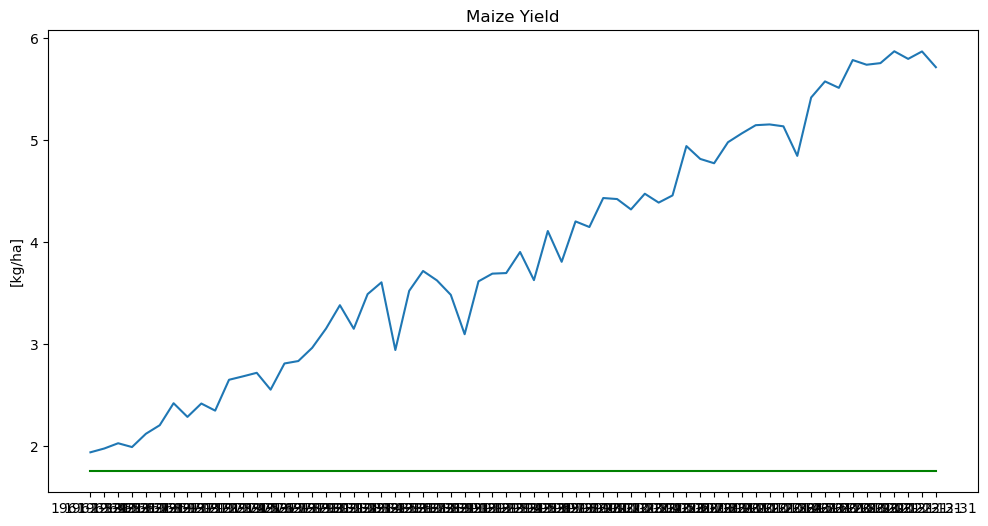

In [114]:
from matplotlib import dates
import matplotlib.dates as mdates

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Maize Yield')
ax.set_ylabel('[kg/ha]');
#ax.grid(True, which='both')
#ax.set_xticks(predictions_denorm.index)
#ax.set_xticklabels(predictions_denorm.index, rotation=70)
#ax.xaxis.set_major_locator(dates.YearLocator(5))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
maize_yield = global_crop_yield_df['Maize (100g/ha)'] / 10000 
pd_maize_yield, = plt.plot(maize_yield, label='Maize Yield')
pd_predictions_best, = plt.plot(model_sample_best / 10000, label='Best Predictions', color='green')
#plt.legend(handles=[pd_maize_yield, pd_predictions_best], loc='upper left')